In [122]:
# -*- coding: utf-8 -*-
# real final
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier, export_graphviz



crime = pd.read_csv('C:/Users/kwon/Desktop/final_merge2_crime(2).csv')
list(crime)
del_list = ['Unnamed: 0','Date','HOUR','Day','UCR_PART_Part One','Low Visibility (mi)','Avg Wind (mph)',
            'High Wind Gust (mph)','Snowfall (in)','Precip (in)','P0020001']
crime = crime.drop(del_list, axis = 1)
crime.dtypes


YEAR                                               int64
MONTH                                              int64
DAY_OF_WEEK                                       object
SHOOTING_Y                                         int64
Low Temp (F)                                       int64
High Humidity (%)                                  int64
Low Humidity (%)                                   int64
Avg Visibility (mi)                                int64
CrimeGunsRecovered                                 int64
GunsRecoveredSafeguard                           float64
BuybackGunsRecovered                             float64
Shooting_Type_V2_Non-Fatal                         int64
Victim_Gender_Male                                 int64
Victim_Race_Black or African American              int64
Victim_Race_White                                  int64
Victim_Ethnicity_NIBRS_Not Hispanic or Latinx      int64
Multi_Victim_t                                     int64
GEOID                          

In [123]:
# vif 구하기
def vif(df1_names,df1):
    reg = LinearRegression()
    
    vif_name = []
    vif_arr = []
    
    for name in df1_names:
        templist = df1_names[:]
        templist.remove(name)
        p1 = templist
        p2 = name
        
        reg.fit(df1[p1], df1[p2])
        vif = 1/(1-reg.score(df1[p1], df1[p2]))
        vif_name.append(name)
        vif_arr.append(vif)
    
    # 출력
    for i in range(len(vif_name)):
        print(str(vif_name[i])+ " - " + str(vif_arr[i]))
    
    return vif_name, vif_arr

In [124]:
# # 최종
# crime_model = crime[:]
# catvar=['DAY_OF_WEEK']
# list(crime_model)
# for c in catvar:
#     dummy = pd.get_dummies(crime_model[c], prefix=c, drop_first=True)
#     crime_model = pd.concat((crime_model,dummy),axis=1)
    
# crime_model = crime_model.drop(catvar, axis = 1)


# 발생, 미발생으로 값 변환
for i in range(len(crime)):
    if crime['final_count'][i]>=1:
        crime['final_count'][i]=1
        

crime_model=crime
# catvar=['DAY_OF_WEEK']
# list(crime_model)
# for c in catvar:
#     dummy = pd.get_dummies(crime_model[c], prefix=c, drop_first=True)
#     crime_model = pd.concat((crime_model,dummy),axis=1)
    
# crime_model = crime_model.drop(catvar, axis = 1)

<ipython-input-124-dfa34dbcbecf>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime['final_count'][i]=1


In [125]:
crime_model['final_count'].value_counts()

0    86857
1    22056
Name: final_count, dtype: int64

In [126]:
trainX = crime_model[crime_model['YEAR']<=2017]
trainY = trainX['final_count']
trainX = trainX.drop(['final_count','YEAR','MONTH','DAY_OF_WEEK'],axis=1)


testX=crime_model[crime_model['YEAR']>2017]
testY = testX['final_count']
testX = testX.drop(['final_count','YEAR','MONTH','DAY_OF_WEEK'],axis=1)


print('trainX shape:', trainX.shape)
print('testX shape:', testX.shape)
print('trainY shape:', trainY.shape)
print('testY shape:', testY.shape)

trainX shape: (102457, 23)
testX shape: (6456, 23)
trainY shape: (102457,)
testY shape: (6456,)


In [127]:
testY.value_counts()

0    5301
1    1155
Name: final_count, dtype: int64

In [128]:
# Decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
clf.fit(trainX, trainY)
y_pred_tr = clf.predict(testX)
print('Decision Tree Accuracy: %.4f' % accuracy_score(testY, y_pred_tr))

scores = cross_val_score(clf, testX, testY, cv=5).mean()
print("cv_score:",scores)

Decision Tree Accuracy: 0.8127
cv_score: 0.7802008666812152


In [129]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)
rfc.fit(trainX, trainY)
y_pred = rfc.predict(testX)
print('Model accuracy score with RandomForest : {0:0.4f}'. 
      format(accuracy_score(testY, y_pred)))

scores = cross_val_score(rfc, testX, testY, cv=5).mean()
print("cv_score:",scores)

Model accuracy score with RandomForest : 0.8130
cv_score: 0.7975507982148382


In [130]:
# 하이퍼 파라미터 선정
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(trainX, trainY)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 10}
최고 예측 정확도: 0.7984


In [131]:
#위의 결과로 나온 최적 하이퍼 파라미터로 다시 모델을 학습하여 테스트 세트 데이터에서 예측 성능을 측정
rf_clf1 = RandomForestClassifier(n_estimators = 100, 
                                max_depth = 6,
                                min_samples_leaf = 12,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf1.fit(trainX, trainY)
pred = rf_clf1.predict(testX)
print('예측 정확도: {:.4f}'.format(accuracy_score(testY,y_pred)))

예측 정확도: 0.8130


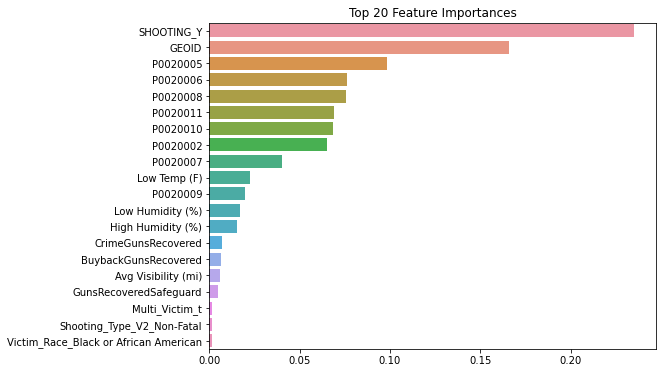

In [132]:
# feauture 중요도선정
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = trainX.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

In [133]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split

knn_clf=KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(trainX, trainY)

y_pred_knn=knn_clf.predict(testX)

print(knn_clf.score(testX,testY)) #calculate accuracy of test data sets. (compare y_pred and ysts)

scores = cross_val_score(knn_clf, testX, testY, cv=5).mean()
print("cv_score:",scores)

0.779275092936803
cv_score: 0.785467022228191


In [134]:
from sklearn.metrics import classification_report

print(classification_report(testY, y_pred))
print(classification_report(testY, y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      5301
           1       0.41      0.11      0.17      1155

    accuracy                           0.81      6456
   macro avg       0.62      0.54      0.53      6456
weighted avg       0.76      0.81      0.77      6456

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      5301
           1       0.22      0.10      0.13      1155

    accuracy                           0.78      6456
   macro avg       0.52      0.51      0.50      6456
weighted avg       0.72      0.78      0.74      6456



Text(0.5, 1.0, 'Confusion Matrix')

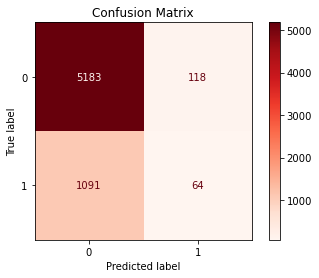

In [135]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

label=['0','1'] # 라벨 설정
plot = plot_confusion_matrix(clf, # 분류 모델
                             testX, testY, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Reds,# 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

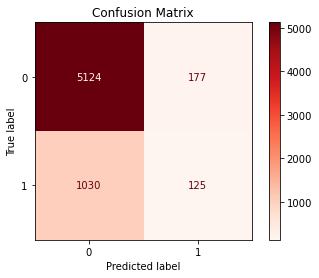

In [136]:
label=['0','1'] # 라벨 설정
plot = plot_confusion_matrix(rfc, # 분류 모델
                             testX, testY, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                             cmap=plt.cm.Reds,# 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

Text(0.5, 1.0, 'Confusion Matrix')

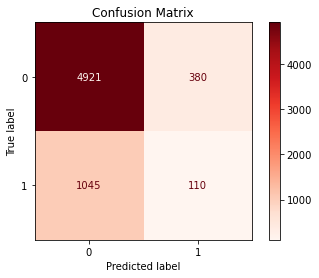

In [137]:
label=['0','1'] # 라벨 설정
plot = plot_confusion_matrix(knn_clf, # 분류 모델
                             testX, testY, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                     cmap=plt.cm.Reds,# 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')

In [ ]:
from sklearn.linear_model import LogisticRegression

logi = LogisticRegression(random_state=0).fit(trainX, trainY)
y_pred_logi=logi.predict(testX)
logi.score(testX,testY)

scores = cross_val_score(logi, testX, testY, cv=5).mean()
print("cv_score:",scores)

In [ ]:
print(classification_report(testY, y_pred_logi))

In [ ]:
label=['0','1'] # 라벨 설정
plot = plot_confusion_matrix(logi, # 분류 모델
                             testX, testY, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=label, # 표에 표시할 labels
                     cmap=plt.cm.Reds,# 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None
plot.ax_.set_title('Confusion Matrix')